### Agentic RAG With LangGraph

In [7]:
!pip install langchain langgraph langchain_openai langchain_community langchain_text_splitters langchain_core
import os
from typing import TypedDict, List
from langgraph.graph import StateGraph, END
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document

In [8]:
import os
from dotenv import load_dotenv
load_dotenv()

False

In [23]:
# Set your OpenAI API key
# Replace 'YOUR_OPENAI_API_KEY' with your actual OpenAI API key
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

# Initialize models
llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)
embeddings = OpenAIEmbeddings()

In [ ]:
llm

ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x000001C7CF964B90>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x000001C7CF9651D0>, root_client=<openai.OpenAI object at 0x000001C7D039DE50>, root_async_client=<openai.AsyncOpenAI object at 0x000001C7CF964E10>, model_name='gpt-4.1', temperature=0.0, model_kwargs={}, openai_api_key=SecretStr('**********'))

## State Definition

In [24]:
class AgentState(TypedDict):
    question: str
    documents: List[Document]
    answer: str
    needs_retrieval: bool

In [25]:
### Sample Docuemnt And VectorStore
# Sample documents for demonstration
sample_texts = [
    "LangGraph is a library for building stateful, multi-actor applications with LLMs. It extends LangChain with the ability to coordinate multiple chains across multiple steps of computation in a cyclic manner.",
    "RAG (Retrieval-Augmented Generation) is a technique that combines information retrieval with text generation. It retrieves relevant documents and uses them to provide context for generating more accurate responses.",
    "Vector databases store high-dimensional vectors and enable efficient similarity search. They are commonly used in RAG systems to find relevant documents based on semantic similarity.",
    "Agentic systems are AI systems that can take actions, make decisions, and interact with their environment autonomously. They often use planning and reasoning capabilities."
]

documents=[Document(page_content=text) for text in sample_texts]

##create vector store
vectorstore = FAISS.from_documents(documents, embeddings)
retriever = vectorstore.as_retriever(k=3)

AuthenticationError: Error code: 401 - {'error': {'message': 'Incorrect API key provided: YOUR_OPE*******_KEY. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}

### Agents function

In [ ]:
def decide_retrieval(state: AgentState) -> AgentState:
    """
    Decide if we need to retrieve documents based on the question
    """
    question = state["question"]

    # Simple heuristic: if question contains certain keywords, retrieve
    retrieval_keywords = ["what", "how", "explain", "describe", "tell me"]
    needs_retrieval = any(keyword in question.lower() for keyword in retrieval_keywords)

    return {**state, "needs_retrieval": needs_retrieval}

In [ ]:
def retrieve_documents(state: AgentState) -> AgentState:
    """
    Retrieve relevant documents based on the question
    """
    question = state["question"]
    documents = retriever.invoke(question)

    return {**state, "documents": documents}

In [ ]:
def generate_answer(state: AgentState) -> AgentState:
    """
    Generate an answer using the retrieved documents or direct response
    """
    question = state["question"]
    documents = state.get("documents", [])

    if documents:
        # RAG approach: use documents as context
        context = "\n\n".join([doc.page_content for doc in documents])
        prompt = f"""Based on the following context, answer the question:

Context:
{context}

Question: {question}

Answer:"""
    else:
        # Direct response without retrieval
        prompt = f"Answer the following question: {question}"

    response = llm.invoke(prompt)
    answer = response.content

    return {**state, "answer": answer}

### conditional Logic

In [ ]:
def should_retrieve(state: AgentState) -> str:
    """
    Determine the next step based on retrieval decision
    """
    if state["needs_retrieval"]:
        return "retrieve"
    else:
        return "generate"

### build the Graph

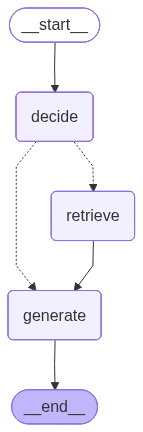

In [ ]:
# Create the state graph
workflow = StateGraph(AgentState)

# Add nodes
workflow.add_node("decide", decide_retrieval)
workflow.add_node("retrieve", retrieve_documents)
workflow.add_node("generate", generate_answer)

# Set entry point
workflow.set_entry_point("decide")

# Add conditional edges
workflow.add_conditional_edges(
    "decide",
    should_retrieve,
    {
        "retrieve": "retrieve",
        "generate": "generate"
    }
)

# Add edges
workflow.add_edge("retrieve", "generate")
workflow.add_edge("generate", END)

# Compile the graph
app = workflow.compile()
app

### test the Agentic System

In [ ]:
def ask_question(question: str):
    """
    Helper function to ask a question and get an answer
    """
    initial_state = {
        "question": question,
        "documents": [],
        "answer": "",
        "needs_retrieval": False
    }

    result = app.invoke(initial_state)
    return result

In [ ]:
# Test with a question that should trigger retrieval
question1 = "What is LangGraph?"
result1 = ask_question(question1)
result1

{'question': 'What is LangGraph?',
 'documents': [Document(id='30677815-a9f6-4f14-8920-5421b5eefb14', metadata={}, page_content='LangGraph is a library for building stateful, multi-actor applications with LLMs. It extends LangChain with the ability to coordinate multiple chains across multiple steps of computation in a cyclic manner.'),
  Document(id='353f0046-6350-426f-b24b-4bfa2a71b093', metadata={}, page_content='RAG (Retrieval-Augmented Generation) is a technique that combines information retrieval with text generation. It retrieves relevant documents and uses them to provide context for generating more accurate responses.'),
  Document(id='a9ecfc07-01f0-450e-ac3f-b345ea2528d0', metadata={}, page_content='Vector databases store high-dimensional vectors and enable efficient similarity search. They are commonly used in RAG systems to find relevant documents based on semantic similarity.'),
  Document(id='062bcab7-fb6e-422a-9e53-e7e7c5a4304b', metadata={}, page_content='Agentic system

In [ ]:
# Test with another question
question2 = "How does RAG work?"
result2 = ask_question(question2)

print(f"Question: {question2}")
print(f"Retrieved documents: {len(result2['documents'])}")
print(f"Answer: {result2['answer']}")
print("\n" + "="*50 + "\n")

Question: How does RAG work?
Retrieved documents: 4
Answer: RAG (Retrieval-Augmented Generation) works by combining information retrieval with text generation to produce more accurate and contextually relevant responses. Here’s how it works:

1. **Retrieval Step:**  
   When a user asks a question, the system first retrieves relevant documents or passages from a large collection of data. This is often done using a vector database, which stores documents as high-dimensional vectors and enables efficient similarity search based on the semantic meaning of the query.

2. **Augmentation Step:**  
   The retrieved documents are then used to provide additional context to the language model. This means the model has access to up-to-date or domain-specific information that may not be present in its original training data.

3. **Generation Step:**  
   The language model (such as an LLM) takes both the user’s question and the retrieved context to generate a final, informed response. This helps t